# Model Evaluation

The purpose of this notebook is to evaluate a model that will recommend items of clothing to a customer.

Ir order to do this we simulate the process where a customer uploads a photo that will be compared to the images of products a store is currently selling.

The strategy will be to use a neural network already trained and use it to extract a feature representation of all the store images which we will call embeddings. These embeddings will be saved to a file on disk and when a customer uploads a new image the embedding of that image will be extracted, then we will calculate the distances to all images in our store and return the "n" most similar products.

A variety of different models and distance metrics are evaluated to find out what provides the best performance.

In [1]:
import os
import sys
import re
import shutil
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
from tqdm import tqdm_notebook
from PIL import Image
import cv2
from scipy.spatial.distance import cdist
%matplotlib inline
pd.options.mode.chained_assignment = None  #disables .loc assignment warning
    
import sys
sys.path.insert(0, "../utils")
from utils import read_image, bbox_corners, crop_image, find_paths, save_embeddings, rank_recommendations
    
#loaded three different models to test which one perfomrs better
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import preprocess_input as prep_input_RN50
from keras.applications.vgg16 import preprocess_input as prep_input_VGG16
from keras.applications.mobilenet import preprocess_input as prep_input_MN
#pip install h5py==2.8.0rc1 to disable the h5py warning

Using TensorFlow backend.


## Selecting the dataset

We will start from the valid and test sets that have been explored and commented on the previous notebook.

In [2]:
customer_df = pd.read_csv("./customer_df.csv")
retrieval_df = pd.read_csv("./retrieval_df.csv")

In [3]:
#filtering by unique photos so only single-labeled images are selected
freq_categories = pd.DataFrame(customer_df["photo"].value_counts())
freq_categories = freq_categories[freq_categories["photo"] == 1]
customer_df = customer_df[customer_df["photo"].isin(freq_categories.index)]

In [4]:
#finding matches
matches_df = customer_df.merge(retrieval_df, how="inner", on="id", suffixes=("_cust", "_retr"))
matches_df = matches_df[matches_df["category_cust"].isin(["dresses", "tops"])]

In [5]:
np.random.seed(2018) #controls permutation
#matched items
perm = np.random.permutation(matches_df['product_cust'].unique()) #permutes list of photos randomly
split = int(len(matches_df['product_cust'].unique())*0.5) #finding total unique products
valid, test = np.split(perm, [split]) #splits list into valid and test
valid_df = matches_df[matches_df['product_cust'].isin(valid)]
test_df = matches_df[matches_df['product_cust'].isin(test)]

In [6]:
#creating customer and retrieval sets for validation and test
valid_df_cust = customer_df[customer_df['photo'].isin(valid_df["photo_cust"].unique())]
valid_df_retr = retrieval_df[retrieval_df['photo'].isin(valid_df["photo_retr"].unique())]

test_df_cust = customer_df[customer_df['photo'].isin(test_df["photo_cust"].unique())]
test_df_retr = retrieval_df[retrieval_df['photo'].isin(test_df["photo_retr"].unique())]

#critical step so retrieval images are in the same order as the embeddings file that we will create later on
valid_df_retr = valid_df_retr.sort_values(by="photo")
test_df_retr = test_df_retr.sort_values(by="photo")

### Copying photos to new directories

In [7]:
original_dataset_path = "../photos_resized"

for step in zip([valid_df , test_df], ["validation", "test"]):
    photos_list_cust = step[0]["photo_cust"].unique().tolist()
    photos_list_cust = [str(photo) + ".jpg" for photo in photos_list_cust]

    photos_list_retr = step[0]["photo_retr"].unique().tolist()
    photos_list_retr = [str(photo) + ".jpg" for photo in photos_list_retr]

    output_path = os.path.join("..", "photos_evaluation", step[1])
    if not os.path.exists(output_path):
        os.makedirs(output_path, exist_ok=True)
        os.makedirs(os.path.join(output_path, "customer"))
        os.makedirs(os.path.join(output_path, "retrieval"))

    print("Creating customer " + step[1] + " images")
    for photo in tqdm_notebook(photos_list_cust):
        shutil.copy(os.path.join(original_dataset_path, photo), os.path.join(output_path, "customer", photo))

    print("Creating retrieval " + step[1] + " images")
    for photo in tqdm_notebook(photos_list_retr):
        shutil.copy(os.path.join(original_dataset_path, photo), os.path.join(output_path, "retrieval", photo))

Creating customer validation images



Creating retrieval validation images



Creating customer test images



Creating retrieval test images


## Creating embeddings

- We will start by chosing an already trained neural network and removing the bottom layers since our intention is to use it for feature extraction and not for classification. For this purpose we will start with VGG16 due to its popularity and the small ouput when doing feature extraction (512 dimensions)
- Then we will extract features for each of the images from the specified retrieval directory and save it to disk to keep us from doing this process every time.
- Once this file is created we load it up so we can start comparing new images to the retrieval images.

In [8]:
dataset_path = os.path.join("..", "photos_evaluation")
retrieval_val_path = os.path.join(dataset_path, "validation", "retrieval")

In [9]:
resizing = (250,250)
shape_output = 512
model = VGG16(weights="imagenet", include_top=False, pooling="avg")
preprocess_input = prep_input_VGG16

# include_top=False removes the fully connected layer at the end/top of the network. This allows us to get the feature vector as opposed to a classification.
# pooling='avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.

In [10]:
%%time
#Only run the first time so we can compare a customer image to the retrieval images
save_embeddings(retrieval_val_path, "embeddings_vgg.npy", model, preprocess_input, shape_output, resize=resizing)

100%|██████████████████████████████████████████████████████████████████████████████| 5407/5407 [03:04<00:00, 29.28it/s]


Wall time: 3min 4s


In [11]:
embs_retrieval = np.load("./embeddings_vgg.npy")

## Visual inspection

The strategy is to use the already loaded function rank_recommendations which works as a K-Neighbors Search algorithm suited for our case.

We create a rank_similar function that orders the retrieval set based on similarity and keeps only the highest ranked image for each product. Note that a product in retrieval may have more than one photo, this is determined by the "id" feature, usually these are photos from different angles and distances, the intention is to use all this photos to increase the performance of the model when matching a customer photo to retrieval and then only take into account the highest ranked image for each product.

Then we create a show_recommend function to allow us to visually inspect images from the customer dataset.

In [12]:
def rank_similar(target_img, customer_df, retrieval_df, rank):
    """ Finds the image id in the customer_df, and ranks all images by similarity keeping only highest match for each product.    
    Returns retrieval_df ranked and the rank of the matching product"""
    
    img_name = re.split("(\\d+)", target_img)[-2]
    target_df = customer_df[customer_df["photo"] == int(img_name)] #finds image name
    target_id = target_df["id"].unique().tolist()[0] #finds its image id
    
    retrieval_ranked = retrieval_df.iloc[rank] #ranks based on similarity
    retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each product is taken into account
    retrieval_ranked = retrieval_ranked.reset_index(drop=True) #resets index
    same_image_rank = retrieval_ranked[retrieval_ranked["id"] == target_id].index.values.tolist() #extracts index positions for matching product
    return same_image_rank, retrieval_ranked

def show_image(img_array, img_path=None, customer_df=None, title="Image", bbox=False):
    """ Helper function to plot images given an array and optionally plot the bbox"""
    
    fig,ax = plt.subplots(1, figsize=(5,5))
    ax.imshow(img_array)
    plt.title(title)
    plt.axis("off")
    
    if bbox == True:
        top, left, width, height = bbox_corners(img_path, customer_df)
        rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

def show_recommend(top_n, dataset_path, img_path, customer_df, retrieval_ranked, resize, bbox=True):
    """ Shows customer images before and after cropping and the "top_n" retrieval recommendations for visual inspection"""
    
    img_array = read_image(target_img)
    show_image(img_array, img_path, customer_df, title = "User image", bbox=bbox)
    if bbox==True:
        cropped = crop_image(img_path, customer_df, resize=resize)
        show_image(cropped, title="Cropped image")
    
    img_paths = retrieval_ranked['photo'][:top_n]
    print("Top {} similar images".format(top_n))
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, len(img_paths))
    for n, i in enumerate(img_paths):
        ax = fig.add_subplot(gs[0, n])
        recomend_path = os.path.join(dataset_path, str(i)+".jpg")
        ax.imshow(Image.open(recomend_path))
        ax.axis("off")
    plt.show()

In [13]:
#random sample picks for visual evaluation on below cell, just change the .jpg number for one of these
valid_df_cust.sample(10)["photo"]

16044     11157
14737     14538
18896        31
8741       1234
1311      13825
3947       3200
1350      11879
19952      9502
27540    329911
18884       747
Name: photo, dtype: int64

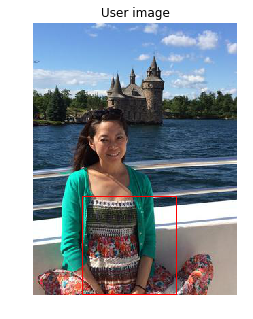

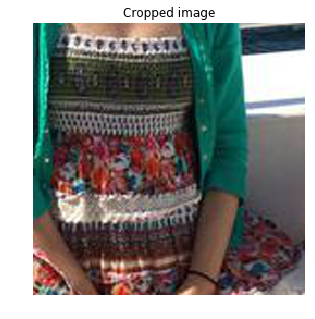

Top 12 similar images


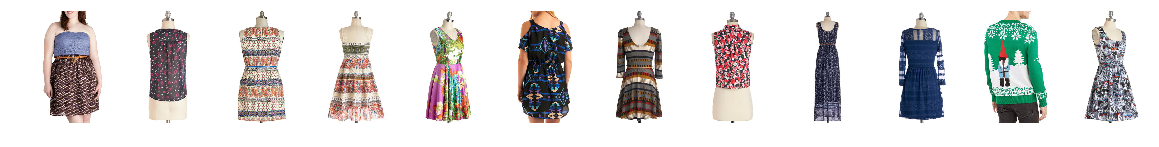

Same images ranked on indices: [3]
Wall time: 1.14 s


In [14]:
%%time
target_img = "../photos_evaluation/validation/customer/11337.jpg"
rank = rank_recommendations(target_img, embs_retrieval, model, preprocess_input,
                            resize=resizing, customer_df=valid_df_cust)

top_n = 12
same_image_rank, retrieval_ranked = rank_similar(target_img, valid_df_cust, valid_df_retr, rank)
show_recommend(top_n, retrieval_val_path, target_img, valid_df_cust, retrieval_ranked, resize=resizing)
print("Same images ranked on indices: {}".format(same_image_rank))

## Measuring model performance

Once we have created an embeddings file from which the most "n" similiar images are returned we need to measure how this process is performing.  
Evaluation will allow us to make improvements when it comes to model selection and hyperparameter tuning.

For the evaluation we will only use customer photos, and each one of them will be compared with the retrieved photos for a potential match.

Our **metric** will be accuracy @ k, where k equals the number of recommendations considered by the metric.  
Accuracy will be defined as: *total number of cases where a match within k occurs / total number of cases*
   
To improve the final accuracy the following distance methods and models will be evaluated:
   - **Distance methods**: euclidean, cosine, chebyshev
   - **Pre-Trained models**: VGG16, ResNet50, MobileNet

In [15]:
def evaluate(customer_df, retrieval_df, embs_retrieval, k_list, val_test, model, preprocessing, resize, method="cosine"):
    
    customer_paths = [os.path.join("..", "photos_evaluation", val_test, "customer", str(img) + ".jpg")
                      for img in customer_df["photo"].tolist()] #full path to each photo
    positives = {"dresses": np.zeros((1, len(k_list)))[0],
                 "tops": np.zeros((1, len(k_list)))[0],
                 } #holds number of matches within "k" for each value of k_list for both dresses and tops
    accuracy_all = {"dresses": np.zeros((1, len(k_list)))[0],
                 "tops": np.zeros((1, len(k_list)))[0],
                 } #holds the accuracy for each value of k_list for both dresses and tops
    
    with tqdm_notebook(total=len(customer_paths)) as pbar:    
        for n, customer_path in enumerate(customer_paths):
            photo_name = re.split("(\\d+)", customer_path)[-2] #finding photo name
            image_customer = customer_df[customer_df["photo"] == int(photo_name)] #finding photo id
            image_id = image_customer['id'].tolist()[0] #always same id even if more than >1 rows
            image_category = image_customer["category"].tolist()[0] #finding photo category
            rank = rank_recommendations(customer_path, embs_retrieval, model, preprocessing,
                                        resize=resize, customer_df=customer_df, method=method)
            
            for i, k in enumerate(k_list):
                retrieval_ranked = retrieval_df.iloc[rank] #retrieval ranked
                retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each item is taken into account
                retrieval_ranked_list = retrieval_ranked["id"].tolist()[:k] #takes list of top "k" products

                if image_id in retrieval_ranked_list: #if the product from the customer img matches retrieval_ranked_list we add 1 to the zeros matrix
                    positives[image_category][i] += 1
            pbar.update(1)
        
        for i, k in enumerate(k_list): #iterates over levels of k
            print("****************** Accuracy at {} ******************".format(k))
            for cat in positives.keys(): #iterates over categories
                total_cat = customer_df[customer_df["category"] == cat].shape[0] #total images for each category
                
                accuracy = positives[cat][i] / total_cat #accuracy for each value of k_list
                accuracy_all[cat][i] = accuracy*100
                print("{}: {:.3f}%".format(cat, accuracy*100))
    return accuracy_all

### Fine-tuning -  Distances

In [16]:
%%time
distances = ["euclidean", "cosine", "chebyshev"]
k = [5,10,20,30,40,50]
acc_distances = {}

for distance in distances:
    print("Calculating {} distance\n".format(distance))
    acc = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, "validation", model,
                   preprocess_input, resize=resizing, method=distance)
    acc_distances[distance] = acc

Calculating euclidean distance



****************** Accuracy at 5 ******************
dresses: 5.414%
tops: 7.937%
****************** Accuracy at 10 ******************
dresses: 8.250%
tops: 10.714%
****************** Accuracy at 20 ******************
dresses: 11.971%
tops: 14.484%
****************** Accuracy at 30 ******************
dresses: 14.586%
tops: 17.262%
****************** Accuracy at 40 ******************
dresses: 17.164%
tops: 20.238%
****************** Accuracy at 50 ******************
dresses: 19.521%
tops: 21.627%

Calculating cosine distance



****************** Accuracy at 5 ******************
dresses: 18.895%
tops: 25.794%
****************** Accuracy at 10 ******************
dresses: 26.151%
tops: 35.516%
****************** Accuracy at 20 ******************
dresses: 35.101%
tops: 43.452%
****************** Accuracy at 30 ******************
dresses: 41.878%
tops: 49.206%
****************** Accuracy at 40 ******************
dresses: 47.072%
tops: 53.571%
****************** Accuracy at 50 ******************
dresses: 51.160%
tops: 56.151%

Calculating chebyshev distance



****************** Accuracy at 5 ******************
dresses: 1.621%
tops: 2.381%
****************** Accuracy at 10 ******************
dresses: 3.278%
tops: 3.571%
****************** Accuracy at 20 ******************
dresses: 5.267%
tops: 6.548%
****************** Accuracy at 30 ******************
dresses: 6.667%
tops: 8.532%
****************** Accuracy at 40 ******************
dresses: 8.140%
tops: 9.524%
****************** Accuracy at 50 ******************
dresses: 9.355%
tops: 11.706%

Wall time: 12min 40s


In [17]:
joblib.dump(acc_distances, "./pkl_objects/acc_distances.pkl") #saving accuracy for each distance and category on a file

['./pkl_objects/acc_distances.pkl']

In [18]:
acc_distances = joblib.load("./pkl_objects/acc_distances.pkl")

In [19]:
col_names = ["acc@5", "acc@10", "acc@20", "acc@30", "acc@40", "acc@50"]

df_dresses = pd.DataFrame(acc_distances).loc["dresses"]
df_dresses = pd.DataFrame(df_dresses.values.tolist(), index=df_dresses.index, columns=col_names).T

df_tops = pd.DataFrame(acc_distances).loc["tops"]
df_tops = pd.DataFrame(df_tops.values.tolist(), index=df_tops.index, columns=col_names).T

In [20]:
def plot_acc(dataframes, titles, ylim=100):
    """Given a list of dataframes it plots each one of them with its corresponding title"""   
    plt.figure(figsize=(16,5))    
    for n, df in enumerate(zip(dataframes, titles)):
        ax = plt.subplot(1,len(dataframes), n+1)
        ax.plot(df[0])
        ax.set_xticks(np.arange(len(df[0].index)))
        ax.set_xticklabels(df[0].index)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylim([0,ylim])
        ax.legend(df[0].columns, frameon=False, loc=2)
        plt.title(df[1])

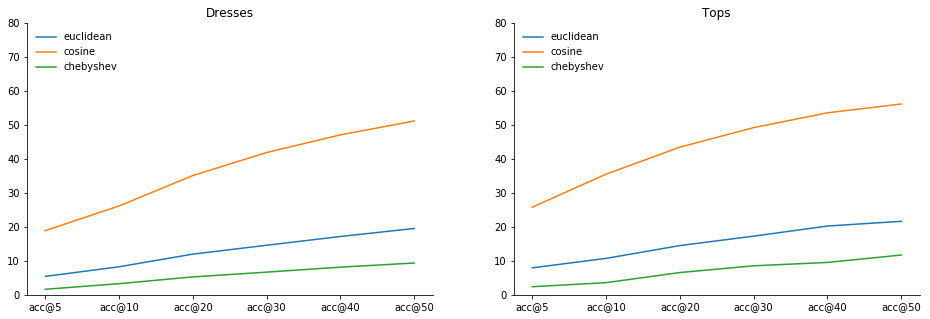

In [21]:
titles = ["Dresses", "Tops"]
dataframes = [df_dresses, df_tops]

plot_acc(dataframes, titles, ylim=80)

### Selecting Model

In [22]:
nn_VGG16 = VGG16(weights="imagenet", include_top=False, pooling="avg")
nn_Mobile = MobileNet(input_shape=(224, 224, 3), weights="imagenet", include_top=False, pooling="avg")
nn_ResNet50 = ResNet50(weights="imagenet", include_top=False, pooling="avg")

In [23]:
%%time
k = [5,10,20,30,40,50]
distance = "cosine"
models = [nn_VGG16, nn_ResNet50, nn_Mobile]
prep_inputs = [prep_input_VGG16, prep_input_RN50, prep_input_MN]
shapes = [512, 2048, 1024]
resizings = [(250,250), (250,250), (224,224)]

acc_models = {}

for n in zip(models, prep_inputs, shapes, resizings):
    model, preprocess_input, shape, resizing = n[0], n[1], n[2], n[3]
    print("Calculating {}\n".format(model.name))
    save_embeddings(retrieval_val_path, file_name="embeddings_val.npy", 
                model=model, preprocessing=preprocess_input, shape=shape, resize=resizing)
    embs_retrieval = np.load("./embeddings_val.npy")
    acc = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, "validation", model,
                   preprocess_input, resize=resizing, method=distance)
    acc_models[model.name] = acc

Calculating vgg16



100%|██████████████████████████████████████████████████████████████████████████████| 5407/5407 [03:24<00:00, 26.47it/s]


****************** Accuracy at 5 ******************
dresses: 18.895%
tops: 25.794%
****************** Accuracy at 10 ******************
dresses: 26.151%
tops: 35.516%
****************** Accuracy at 20 ******************
dresses: 35.101%
tops: 43.452%
****************** Accuracy at 30 ******************
dresses: 41.878%
tops: 49.206%
****************** Accuracy at 40 ******************
dresses: 47.072%
tops: 53.571%
****************** Accuracy at 50 ******************
dresses: 51.160%
tops: 56.151%

Calculating resnet50



100%|██████████████████████████████████████████████████████████████████████████████| 5407/5407 [03:22<00:00, 26.70it/s]


****************** Accuracy at 5 ******************
dresses: 32.928%
tops: 31.349%
****************** Accuracy at 10 ******************
dresses: 41.142%
tops: 40.278%
****************** Accuracy at 20 ******************
dresses: 51.455%
tops: 48.413%
****************** Accuracy at 30 ******************
dresses: 58.637%
tops: 53.770%
****************** Accuracy at 40 ******************
dresses: 63.425%
tops: 57.143%
****************** Accuracy at 50 ******************
dresses: 67.035%
tops: 60.119%

Calculating mobilenet_1.00_224



100%|██████████████████████████████████████████████████████████████████████████████| 5407/5407 [01:12<00:00, 74.83it/s]


****************** Accuracy at 5 ******************
dresses: 33.517%
tops: 35.317%
****************** Accuracy at 10 ******************
dresses: 41.584%
tops: 44.246%
****************** Accuracy at 20 ******************
dresses: 51.050%
tops: 51.786%
****************** Accuracy at 30 ******************
dresses: 56.943%
tops: 56.944%
****************** Accuracy at 40 ******************
dresses: 60.994%
tops: 60.119%
****************** Accuracy at 50 ******************
dresses: 64.530%
tops: 63.690%

Wall time: 26min 54s


In [24]:
joblib.dump(acc_models, "./pkl_objects/acc_models.pkl") #saving accuracy for each model and category on a file

['./pkl_objects/acc_models.pkl']

In [25]:
acc_models = joblib.load("./pkl_objects/acc_models.pkl")

In [26]:
df_dresses = pd.DataFrame(acc_models).loc["dresses"]
df_dresses = pd.DataFrame(df_dresses.values.tolist(), index=df_dresses.index, columns=col_names).T

df_tops = pd.DataFrame(acc_models).loc["tops"]
df_tops = pd.DataFrame(df_tops.values.tolist(), index=df_tops.index, columns=col_names).T

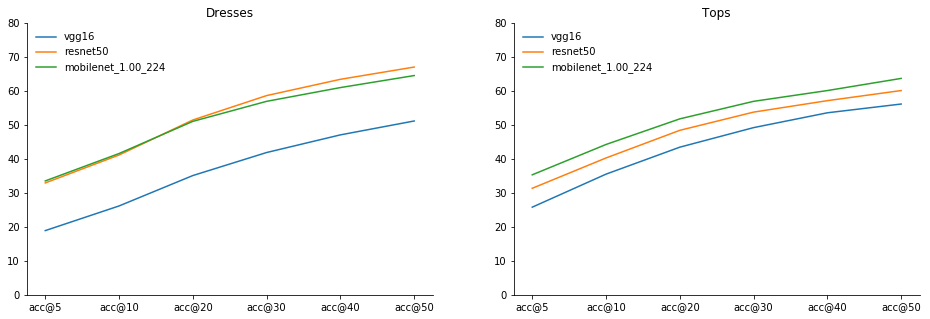

In [27]:
titles = ["Dresses", "Tops"]
dataframes = [df_dresses, df_tops]

plot_acc(dataframes, titles, ylim=80)

### Results
Based on these results we will select the **cosine** method to measure the similarity between a pair of images:

$$sim(A,B) = cos(\theta) = \frac{A \cdot B}{||A||||B||}$$  <img src="../static/img/cosine.png" width="350"/>

With respect to the models we will choose **MobileNet**. 

Despite having performed slightly lower than ResNet50 for dresses, MobileNets are usually considered to be used on mobile devices or servers due to being small and having low-latency, which helps to meet the resource constraints of a variety of use cases. These Convolutional Neural Network trade off a reasonable amount of accuracy to reduce size and latency.

Although MobileNet was initially trained for classification, the results obtained to calculate similarities are acceptable for the purpose of this project. 

Other options were initially explored at this stage, and we concluded that the leading algortihm for this problematic is using a siamese architecture with a triple-loss cost function that allows to train a network to discriminate based on similarity. This method was previously attempted however we find it beyond our knowledge scope and resources at this moment.

<img src="../static/img/mobilenet.jpg" width="1000">

## Final validation and test

In [28]:
k = [5,10,20,30,40,50]
distance = "cosine"
model = nn_Mobile
preprocess_input = prep_input_MN
shape = 1024
resizing = (224,224)

In [29]:
#Validation
save_embeddings(os.path.join(dataset_path, "validation", "retrieval"), file_name="embeddings_val.npy", 
                model=model, preprocessing=preprocess_input, resize=resizing, shape=shape)

embs_retrieval = np.load("./embeddings_val.npy")
acc_valid = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, "validation", model,
                     preprocess_input, resize=resizing, method=distance)
joblib.dump(acc_valid, "./pkl_objects/acc_valid.pkl") #saving accuracy for each category on a file

100%|██████████████████████████████████████████████████████████████████████████████| 5407/5407 [01:23<00:00, 64.72it/s]


****************** Accuracy at 5 ******************
dresses: 33.517%
tops: 35.317%
****************** Accuracy at 10 ******************
dresses: 41.584%
tops: 44.246%
****************** Accuracy at 20 ******************
dresses: 51.050%
tops: 51.786%
****************** Accuracy at 30 ******************
dresses: 56.943%
tops: 56.944%
****************** Accuracy at 40 ******************
dresses: 60.994%
tops: 60.119%
****************** Accuracy at 50 ******************
dresses: 64.530%
tops: 63.690%



['./pkl_objects/acc_valid.pkl']

In [30]:
acc_valid = joblib.load("./pkl_objects/acc_valid.pkl")

In [31]:
#Test
save_embeddings(os.path.join(dataset_path, "test", "retrieval"), file_name="embeddings_test.npy", 
                model=model, preprocessing=preprocess_input, resize=resizing, shape=shape)

embs_retrieval = np.load("./embeddings_test.npy")
acc_test = evaluate(test_df_cust, test_df_retr, embs_retrieval, k, "test", model,
                    preprocess_input, resize=resizing, method=distance)
joblib.dump(acc_test, "./pkl_objects/acc_test.pkl") #saving accuracy for each category on a file

100%|██████████████████████████████████████████████████████████████████████████████| 5435/5435 [01:15<00:00, 71.71it/s]


****************** Accuracy at 5 ******************
dresses: 32.718%
tops: 31.911%
****************** Accuracy at 10 ******************
dresses: 41.404%
tops: 39.837%
****************** Accuracy at 20 ******************
dresses: 52.045%
tops: 50.000%
****************** Accuracy at 30 ******************
dresses: 58.125%
tops: 55.894%
****************** Accuracy at 40 ******************
dresses: 62.106%
tops: 59.756%
****************** Accuracy at 50 ******************
dresses: 65.834%
tops: 63.618%



['./pkl_objects/acc_test.pkl']

In [32]:
acc_test = joblib.load("./pkl_objects/acc_test.pkl")

In [33]:
df_valid = pd.DataFrame(acc_valid, index=col_names)
df_test = pd.DataFrame(acc_test, index=col_names)

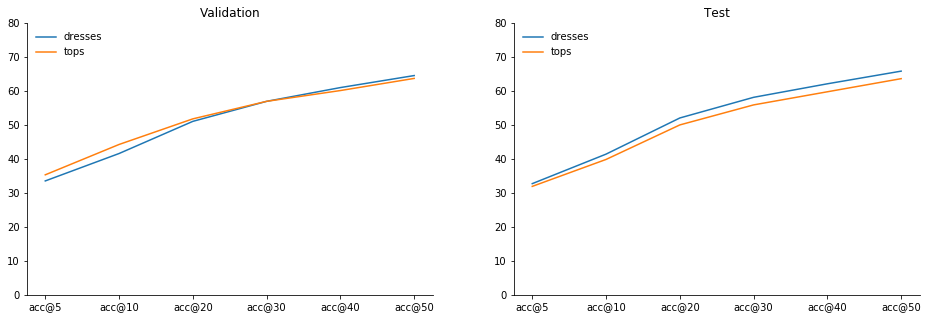

In [34]:
titles = ["Validation", "Test"]
dataframes = [df_valid, df_test]

plot_acc(dataframes, titles, ylim=80)